In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('/kaggle/input/5year-asian-paint/ASIANPAINT.NS (1).csv')
df = df.dropna(subset=['Adj Close'])
# df['New_Price'] = (df.splitFactor).replace(np.inf, 1).cumprod() * df.close
# df['close'] = df['New_Price'] / 20



In [2]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1231,2024-06-05,2864.500000,3027.300049,2864.500000,2961.750000,2933.368164,2410576.0
1232,2024-06-06,2960.000000,2961.750000,2882.250000,2904.800049,2876.963867,1689408.0
1233,2024-06-07,2904.800049,2943.100098,2888.850098,2927.699951,2899.644287,1600180.0
1234,2024-06-10,2928.000000,2951.899902,2915.000000,2937.550049,2909.400146,876867.0
1236,2024-06-12,2909.000000,2918.000000,2865.649902,2905.800049,2905.800049,1701408.0


In [3]:
df1=df.reset_index()['Adj Close']

In [4]:
df1.tail()

1231    2933.368164
1232    2876.963867
1233    2899.644287
1234    2909.400146
1235    2905.800049
Name: Adj Close, dtype: float64

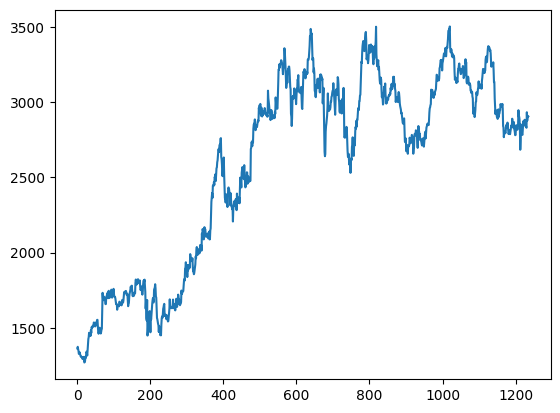

In [5]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
df1.shape

(1236, 1)

In [8]:
training_size=int(len(df1)*0.7)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [9]:
training_size,test_size

(865, 371)

In [10]:
train_data[:10]

array([[0.04165054],
       [0.0466632 ],
       [0.03947776],
       [0.03483068],
       [0.02540771],
       [0.02588099],
       [0.03057097],
       [0.02667694],
       [0.02372968],
       [0.01811457]])

In [11]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [12]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [13]:
print(X_train.shape)
print(y_test.shape)

(764, 100)
(270,)


In [14]:
# need 3d model for stacked lstm
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

2024-07-28 04:16:23.088245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 04:16:23.088417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 04:16:23.243419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.0000e+00 - loss: 0.2296 - val_accuracy: 0.0037 - val_loss: 0.0029
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.0000e+00 - loss: 0.0153 - val_accuracy: 0.0037 - val_loss: 0.0044
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.0000e+00 - loss: 0.0101 - val_accuracy: 0.0037 - val_loss: 0.0098
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.0000e+00 - loss: 0.0058 - val_accuracy: 0.0037 - val_loss: 0.0022
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.0000e+00 - loss: 0.0037 - val_accuracy: 0.0037 - val_loss: 0.0031
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.0000e+00 - loss: 0.0033 - val_accuracy: 0.0037 - val_loss: 0.0022
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.0000e+00 - loss: 0.0030 - val_accuracy: 0.0037 - val_loss: 0.0021
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.00

In [19]:
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# Print the test loss
print("Test loss:", test_loss)

Test loss: 0.0004204165597911924


In [20]:
import pickle

# Save the model to a.pkl file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [21]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

# Open the file in read-binary ('rb') mode and load the model
with open('/kaggle/input/trained-model/model.pkl', 'rb') as file:
    model = pickle.load(file)

In [22]:
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# Print the test loss
print("Test loss:", test_loss)

Test loss: 0.00168631412088871


In [23]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [24]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [25]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
print(len(test_predict))
print(len(train_predict))

270
764


In [27]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

2576.6027284129473

In [28]:
math.sqrt(mean_squared_error(y_test,test_predict))

3064.002426916406

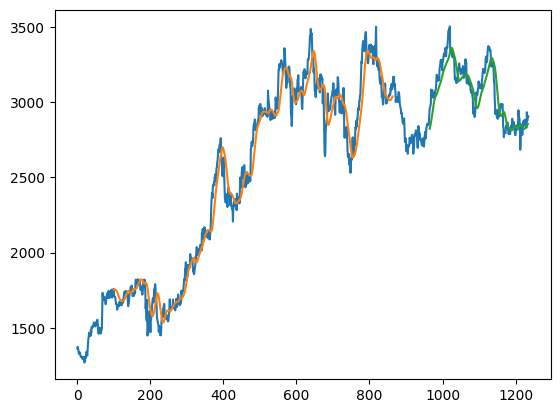

In [29]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [30]:
len(test_data)

371

In [31]:
x_input=test_data[271:].reshape(1,-1)
x_input.shape

(1, 100)

In [32]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.8894596879496273,
 0.8848487778710137,
 0.8831196046159131,
 0.893316939802898,
 0.8691096073889788,
 0.8343281106754039,
 0.8352148829833956,
 0.7859354128517453,
 0.7614398848207014,
 0.7391610688833745,
 0.7510652826426234,
 0.7413336285162948,
 0.7429962445062468,
 0.7303604491997018,
 0.733441857371012,
 0.7250401434780573,
 0.7310698452903808,
 0.7533263660972229,
 0.730471377825733,
 0.7402472940867253,
 0.7412006236598654,
 0.7490923943575001,
 0.7512204734033185,
 0.7690213836708131,
 0.7651862084955889,
 0.7608414173560536,
 0.7668488244855409,
 0.7624818478893882,
 0.7693981035572655,
 0.7554545543692606,
 0.703359904231597,
 0.69941401888278,
 0.6705070336684815,
 0.682721518827605,
 0.687088605097625,
 0.687088605097625,
 0.682056494545457,
 0.6851157168125017,
 0.7042909386742526,
 0.7070841512284383,
 0.7067737701546961,
 0.699680028595639,
 0.7139118830746363,
 0.7029608896623083,
 0.6936281408790499,
 0.6797067771476624,
 0.6840515682871977,
 0.6823889518495971,
 0.

In [33]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

# print(lst_output)

[0.71461314]
101
1 day output [[0.7167031]]
2 day output [[0.7184738]]
3 day output [[0.7198869]]
4 day output [[0.7209615]]
5 day output [[0.7217453]]
6 day output [[0.722297]]
7 day output [[0.72267234]]
8 day output [[0.72292143]]
9 day output [[0.7230841]]
10 day output [[0.7231907]]
11 day output [[0.7232622]]
12 day output [[0.72331387]]
13 day output [[0.72335464]]
14 day output [[0.7233899]]
15 day output [[0.72342265]]
16 day output [[0.7234545]]
17 day output [[0.72348535]]
18 day output [[0.7235155]]
19 day output [[0.72354454]]
20 day output [[0.72357213]]
21 day output [[0.723598]]
22 day output [[0.7236222]]
23 day output [[0.7236446]]
24 day output [[0.7236652]]
25 day output [[0.7236843]]
26 day output [[0.7237021]]
27 day output [[0.72371835]]
28 day output [[0.7237335]]
29 day output [[0.7237476]]


In [34]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [35]:
len(df1)

1236

In [36]:
# print(scaler.inverse_transform(df1[1136:]))

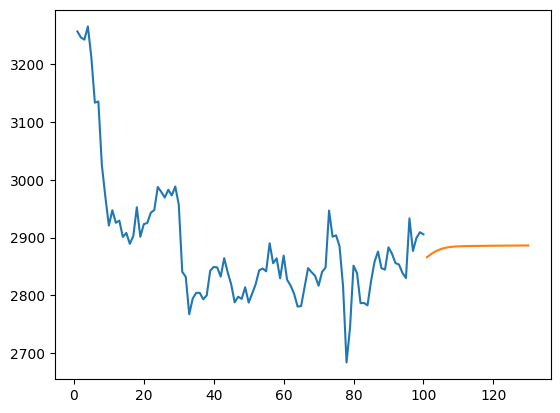

In [37]:
plt.plot(day_new,scaler.inverse_transform(df1[1136:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

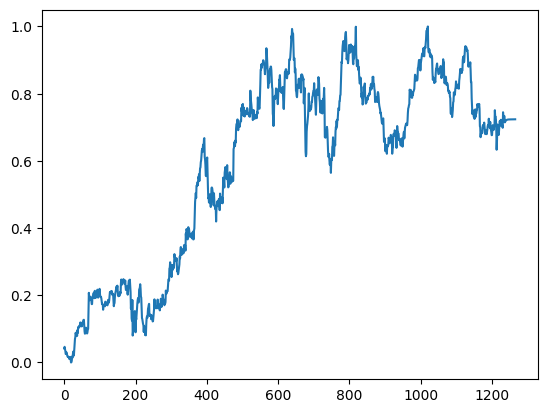

In [38]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[:])

In [39]:
df3=scaler.inverse_transform(df3).tolist()

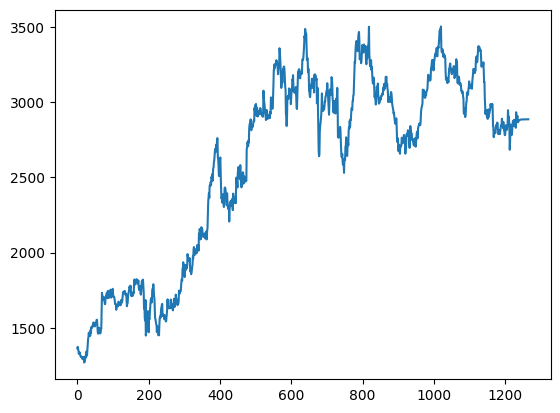

In [40]:
plt.plot(df3)

In [41]:
stock_price=scaler.inverse_transform(lst_output)


In [42]:
for i in range(len(stock_price)):
    day_price=stock_price[i].item()
    print("Price on Day",i+1,"is",day_price)

Price on Day 1 is 2866.100714124222
Price on Day 2 is 2870.7695057119286
Price on Day 3 is 2874.725009695958
Price on Day 4 is 2877.881743410347
Price on Day 5 is 2880.282315037508
Price on Day 6 is 2882.0332450334677
Price on Day 7 is 2883.2656867097116
Price on Day 8 is 2884.104135849222
Price on Day 9 is 2884.660572081398
Price on Day 10 is 2885.0239399870234
Price on Day 11 is 2885.262146356816
Price on Day 12 is 2885.421793890288
Price on Day 13 is 2885.5372354345086
Price on Day 14 is 2885.628310424412
Price on Day 15 is 2885.707135561873
Price on Day 16 is 2885.7802352248223
Price on Day 17 is 2885.851337629221
Price on Day 18 is 2885.920309624499
Price on Day 19 is 2885.9876838129367
Price on Day 20 is 2886.052528140544
Price on Day 21 is 2886.11417685447
Price on Day 22 is 2886.171964201865
Price on Day 23 is 2886.2260233332995
Price on Day 24 is 2886.2760879476327
Price on Day 25 is 2886.3220248942944
Price on Day 26 is 2886.3647662272756
Price on Day 27 is 2886.4044450971464